# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import time

tempo_agora = time.time() # Tempo inicial

## 0.1 Loading Datasets

In [2]:
billiard_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\bar_sales_forecast\\data\\raw\\billiard.csv', low_memory=False)
sales_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\bar_sales_forecast\\data\\raw\\sales.csv')

billiard_cols = ['#No', 'Name', '#Start Time', 'In Use', 'Semana', 'Turno', 'Total Bilhar', 'Pago', '#Preço/Hora', 'Data']
billiard = billiard_raw[billiard_cols]

sales_cols = ['#Time', 'Purchaser', 'Item', '#Voucher', 'Semana', 'Turno', 'Classe 1', 'Classe 2', 'Classe 3', 'Preço', 'Margem', 'Total Venda', 'Data', 'Quantidade']
sales = sales_raw[sales_cols]

In [3]:
billiard.head(5)

,#No,Name,#Start Time,In Use,Semana,Turno,Total Bilhar,Pago,#Preço/Hora,Data
0,848,***Quarta1***,1/00:45,0:15,5,Noite,2.0,2.00,3.5,5/31/2017
1,829,Guest(30),31/18:06,6:24,5,Tarde,0.0,24.60,0.0,5/31/2017
2,836,Guest(28),31/20:46,4:28,5,Tarde,0.0,4.50,0.0,5/31/2017
3,838,Guest(27),31/20:57,3:25,5,Tarde,0.0,29.72,0.0,5/31/2017
4,844,Guest(14),31/22:16,2:47,5,Noite,0.0,48.30,0.0,5/31/2017


In [4]:
sales.head(5)

,#Time,Purchaser,Item,#Voucher,Semana,Turno,Classe 1,Classe 2,Classe 3,Preço,Margem,Total Venda,Data,Quantidade
0,2/23:50:26,Mesa 1,10%,150,1,Noite,Gorjeta,NaN,NaN,0.1,0.0,1.6,5/2/2017,16
1,2/23:56:18,Mesa 5,10%,151,1,Noite,Gorjeta,NaN,NaN,0.1,0.0,3.7,5/2/2017,37
2,3/00:43:47,Mesa 1,10%,153,1,Noite,Gorjeta,NaN,NaN,0.1,0.0,1.5,5/2/2017,15
3,3/01:04:07,Mesa 5,10%,155,1,Noite,Gorjeta,NaN,NaN,0.1,0.0,2.4,5/2/2017,24
4,3/00:43:35,Mesa 1,Agua s/ Gás,153,1,Noite,Bar,Sem Álcool,NaN,3.0,1.5,6.0,5/2/2017,2


## 0.2 Helper Functions

In [5]:
# identificando outliers
def busca_outliers(df, series):
    q1 = np.percentile(df[series], 25)
    q3 = np.percentile(df[series], 75)
    distancia = q3 - q1
    salto = distancia * 1.5
    li = q1 - salto
    ls = q3 + salto
    indices = df[(df[series]<li)|(df[series]>ls)].index
#     print(f'O limite inferior é: {li}\nO limite superior é: {ls}\nHá {len(indices)} outliers')
    return indices, li, ls

def metrics(y_test, y_hat):
    # metrics
    mean_absolute_error = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_hat))) # mean absolute error
    mean_absolute_percentage_error = np.mean(mean_absolute_error / np.expm1(y_test)) # mean absolute percentage error

    print(f"MAE: {mean_absolute_error}")
    print(f"MAPE: {mean_absolute_percentage_error}")
    print(f"RMSE: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_hat)))}")
    
def cross_validation(df, error, kfold, model_name, model):
    list_mean_absolute_error, list_mean_absolute_percentage_error, list_root_mean_squared_error, folds = [], [], [], []
    for i in reversed(range(1, kfold+1)):
        folds.append(f'Fold: {i}')
        validation_start_date = df.index.max() - pd.Timedelta(6*i, 'w')
        validation_end_date = df.index.max() - pd.Timedelta(6*(i-1), 'w')
        
        train = df[df.index<validation_start_date]
        validation = df[(df.index>=validation_start_date)&(df.index<=validation_end_date)]
        
        X_train = train.drop('total', axis=1)
        y_train = train['total']
        
        X_val = validation.drop('total', axis=1)
        y_val = validation['total']
        
        # fiting model
        model_fit = model.fit(X_train, y_train)

        # predicting
        y_hat = model_fit.predict(X_val)
        
        list_mean_absolute_error.append(np.mean(np.abs(np.expm1(y_val) - np.expm1(y_hat))))
        list_mean_absolute_percentage_error.append(np.mean(np.abs(np.expm1(y_val) - np.expm1(y_hat)) / np.expm1(y_val)))
        list_root_mean_squared_error.append(np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_hat))))
        
    # mean and std
    folds.append('mean_and_std')
    list_mean_absolute_error.append(str(round(np.mean(list_mean_absolute_error), 2))+' +/- '+str(round(np.std(list_mean_absolute_error), 2)))
    list_mean_absolute_percentage_error.append(str(round(np.mean(list_mean_absolute_percentage_error), 2))+' +/- '+str(round(np.std(list_mean_absolute_percentage_error), 2)))
    list_root_mean_squared_error.append(str(round(np.mean(list_root_mean_squared_error), 2))+' +/- '+str(round(np.std(list_root_mean_squared_error), 2)))
    # dataframe
    cross_validation_metrics = pd.DataFrame([list_mean_absolute_error, list_mean_absolute_percentage_error, list_root_mean_squared_error], index=['MAE', 'MAPE', "RMSE"], columns=folds)
    error[model_name] = cross_validation_metrics['mean_and_std']
    return error, cross_validation_metrics

# 1.0 Data Description

## 1.1 Data Dimensions

In [6]:
print(f'Billiard qty of rows: {billiard.shape[0]}')
print(f'Billiard qty of columns: {billiard.shape[1]}')
print()
print(f'Sales qty of rows: {sales.shape[0]}')
print(f'Sales qty of columns: {sales.shape[1]}')

Billiard qty of rows: 45162
Billiard qty of columns: 10

Sales qty of rows: 137609
Sales qty of columns: 14


## 1.2 Datatype

In [7]:
print('billiard\n')
billiard.dtypes

billiard



#No               int64
Name             object
#Start Time      object
In Use           object
Semana            int64
Turno            object
Total Bilhar    float64
Pago            float64
#Preço/Hora     float64
Data             object
dtype: object

In [8]:
print('sales\n')
sales.dtypes

sales



#Time           object
Purchaser       object
Item            object
#Voucher         int64
Semana           int64
Turno           object
Classe 1        object
Classe 2        object
Classe 3        object
Preço          float64
Margem         float64
Total Venda    float64
Data            object
Quantidade       int64
dtype: object

## 1.3 Check NaN values

In [9]:
print('billiard\n')
billiard.isna().sum()

billiard



#No             0
Name            0
#Start Time     0
In Use          0
Semana          0
Turno           0
Total Bilhar    0
Pago            0
#Preço/Hora     0
Data            0
dtype: int64

In [10]:
print('sales\n')
sales.isna().sum()

sales



#Time              0
Purchaser      12447
Item               0
#Voucher           0
Semana             0
Turno              0
Classe 1           0
Classe 2       17048
Classe 3       73892
Preço              0
Margem             0
Total Venda        0
Data               0
Quantidade         0
dtype: int64

O sistema gestor de vendas utilizado tem uma modalidade de vendas que não vincula o produto à uma mesa de consumo, geralmente utilizados quando ocorre uma venda avulsa, que é paga no ato da compra. Tais produtos são inseridos no sistema sem informação no campo "Purchaser", o que justifica os 8930 NaN Values nessa feature. As features Classe 2 e Classe 3 possuem NaN Values porque alguns produtos são cadastrados e classificados apenas no primeiro nível (Classe 1).

## 1.4 Data Cleaning

In [11]:
# billiard

# Adjusting #Start Time to datetimeindex format
billiard['start_time'] = billiard['#Start Time'].apply(lambda x: x.split('/')[1])

# Adjusting #Data to datetime format
billiard['Data'] = billiard['Data'].str.replace('/', '-').str.strip()

# Creating datetime feature with datetime dtype
billiard['datetime'] = billiard['Data'] + '-' + billiard['start_time']
billiard['datetime'] = pd.to_datetime(billiard['datetime'])

# Changing interesting feature names
billiard.rename(columns={'#No':'id'}, inplace=True)
billiard.rename(columns={'Name':'purchaser'}, inplace=True)
billiard.rename(columns={'Total Bilhar':'sale'}, inplace=True)
billiard.rename(columns={'#Preço/Hora':'price'}, inplace=True)
billiard.rename(columns={'Semana':'week'}, inplace=True)
billiard.rename(columns={'Turno':'work_shift'}, inplace=True)
billiard.rename(columns={'In Use':'in_use'}, inplace=True)

#  Creating quantity feature
billiard['quantity'] = round(billiard['sale'] / billiard['price'], 1)

# Creating item feature
billiard['item'] = 'bilhar'

# Droping features
billiard.drop(['Pago', 'Data', 'start_time', '#Start Time'], axis=1, inplace=True)

# sales

# Catch date informations
sales['Time'] = sales['#Time'].apply(lambda x: x.split('/')[1])
sales['datetime'] = sales['Data'] + '-' + sales['Time']

# Creating datetime feature
sales['datetime'] = pd.to_datetime(sales['datetime'])

# Changing interesting feature names
sales.rename(columns={'#Voucher':'id'}, inplace=True)
sales.rename(columns={'Total Venda':'amount'}, inplace=True)
sales.rename(columns={'Preço':'price'}, inplace=True)
sales.rename(columns={'Classe 1':'class1'}, inplace=True)
sales.rename(columns={'Semana':'week'}, inplace=True)
sales.rename(columns={'Turno':'work_shift'}, inplace=True)
sales.rename(columns={'Purchaser':'purchaser'}, inplace=True)
sales.rename(columns={'Item':'item'}, inplace=True)
sales.rename(columns={'Quantidade':'quantity'}, inplace=True)
sales.rename(columns={'Margem':'margin'}, inplace=True)

# multiplying unitary product margin to total margin
sales['margin'] = sales['margin'] * sales['quantity']

# Removing features
sales.drop(['#Time', 'Data', 'Time'], axis=1, inplace=True)

C:\Users\Samoel\AppData\Local\Temp\ipykernel_11952\2971350130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billiard['start_time'] = billiard['#Start Time'].apply(lambda x: x.split('/')[1])
C:\Users\Samoel\AppData\Local\Temp\ipykernel_11952\2971350130.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billiard['Data'] = billiard['Data'].str.replace('/', '-').str.strip()
C:\Users\Samoel\AppData\Local\Temp\ipykernel_11952\2971350130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy 

## 1.5 Creating Dataframe

In [12]:
# concating
df1 = pd.concat([billiard, sales], axis=0)

# Pivoting table to date x class1
df1.loc[df1['item']=='bilhar', 'class1'] = 'Bilhar'
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1['date'] = df1['datetime'].dt.date
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.pivot_table(columns='class1', index='date', values='amount', aggfunc='sum', fill_value=0)
df1['total'] = df1.sum(axis=1)

In [13]:
df1.head()

class1,Bar,Bilhar,Bomboniere,Cozinha,Gorjeta,Tabacaria,total
date,,,,,,,
2017-05-02,169.8,0.0,0.0,24.0,9.2,0.0,203.0
2017-05-03,425.4,18.0,0.0,156.7,35.4,22.0,657.5
2017-05-04,425.3,18.0,0.0,19.9,25.6,0.0,488.8
2017-05-05,937.1,0.0,15.0,431.9,104.5,34.0,1522.5
2017-05-06,1372.1,0.0,12.5,353.2,121.7,25.0,1884.5


## 1.6 Data Dimensions

In [14]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1432
Number of columns: 7


## 1.7 Check NaN values

In [15]:
df1.isnull().sum()

class1
Bar           0
Bilhar        0
Bomboniere    0
Cozinha       0
Gorjeta       0
Tabacaria     0
total         0
dtype: int64

## 1.8 Descriptive Statistics

In [16]:
# central tendency
ct1 = pd.DataFrame(df1.apply(np.mean)).T
ct2 = pd.DataFrame(df1.apply(np.median)).T
# dispersion
d1 = pd.DataFrame(df1.apply(np.std)).T
d2 = pd.DataFrame(df1.apply(np.min)).T
d3 = pd.DataFrame(df1.apply(np.max)).T
d4 = pd.DataFrame(df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1.apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
class1,,,,,,,,
Bar,0.0,2818.89,2818.89,848.299413,705.735,494.963713,0.768592,-0.060985
Bilhar,0.0,256.00,256.00,3.120042,0.000,9.723168,13.920176,326.983515
Bomboniere,0.0,60.00,60.00,5.115363,3.000,6.562343,2.376663,9.265324
Cozinha,0.0,1646.80,1646.80,349.127549,273.100,264.195154,1.130995,1.121061
Gorjeta,0.0,315.10,315.10,70.097416,52.650,58.914178,1.020592,0.566882
Tabacaria,0.0,253.50,253.50,31.152842,22.000,34.119881,1.722110,3.914441
total,0.0,4698.59,4698.59,1306.912626,1070.335,797.800971,0.821651,0.015989


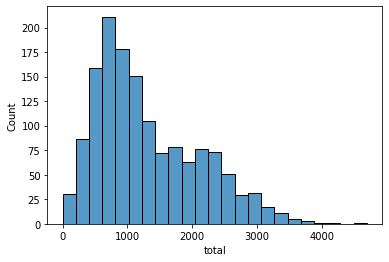

In [17]:
sns.histplot(data=df1, x='total');

# 2.0 Feature Engineering

In [18]:
df2 = df1.copy()

In [19]:
# Day of week
df2 = df2.resample('d').sum()
df2['day_of_week'] = df2.index.day_name()
remover = df2.loc[df2['day_of_week']=='Monday'].index
df2.drop(remover, axis=0, inplace=True)

# Shifted values
df2['shift_1'] = df2['total'].shift(1)
df2['shift_2'] = df2['total'].shift(2)
df2['shift_3'] = df2['total'].shift(3)
df2['shift_5'] = df2['total'].shift(5)
df2['shift_6'] = df2['total'].shift(6)
df2['shift_11'] = df2['total'].shift(11)
df2['shift_12'] = df2['total'].shift(12)
shifteds = 'shift_1 shift_2 shift_3 shift_5 shift_6 shift_11 shift_12'.split()

# day_of_month
df2['day_of_month'] = df2.index.day

# month
df2['month'] = df2.index.month

# 3.0 Business Hypothesis

In [20]:
df3 = df2.copy()

## Contexto: È de entendimento do time de negócios, que os dias semanais têm demandas aparentemente diferentes.
* Sexta-feira e Sábados têm os maiores faturamentos
* Quarta-feira é um dia promocional há mais de 3 anos e apresenta uma demanda inferior às sextas ou sábados, e superior aos demais dias semanais.
* Domingos é um dia promocional mais recente, há por volta de 3 meses, e apresenta um faturamento superior às terça-feiras e às quinta-feiras.

## 3.1 Hyphothesy 01:
### O faturamento total  médio é igual entre os dias semanais: terça-feira e quinta-feira.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

## 3.2 Hyphothesy 02:
### O faturamento total  médio é igual entre os dias semanais: sexta-feira e sábado.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

## 3.3 Hyphothesy 03:
### O faturamento total  médio é igual entre os dias semanais: terça-feira, quarta-feira, quinta-feira e domingo e os dias: sexta-feira e sábado.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

## 3.4 Hyphothesy 04:
### Nos ultimos dois anos, o faturamento total  médio é às quartas-feiras, é igual aos dias: terça-feira, quinta-feira e domingo.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

## 3.5 Hyphothesy 05:
### Nos ultimos três meses, o faturamento total  médio é aos domingos, é igual aos dias: terça-feira e quinta-feira.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

# 4.0 Exploratory Data Analysis 

In [21]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Total

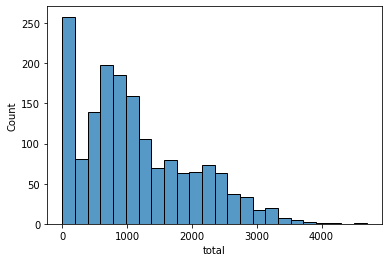

In [22]:
sns.histplot(data=df4, x='total');

## 4.2 Bivariate Analysis

In [23]:
df4 = df3.copy()

### 4.2.1 Amount by the Time

#### 4.2.1.1 Decompose

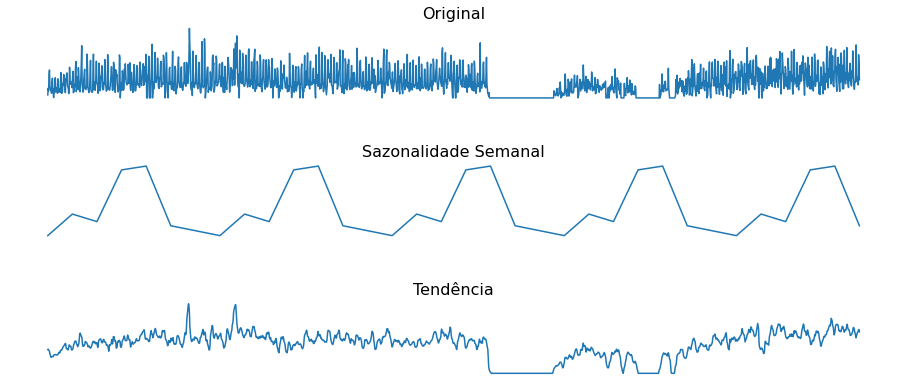

In [24]:
decomp = seasonal_decompose(df4['total'], period=6)

plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace = 0.8)
plt.subplot(4, 1, 1)
ax = decomp.observed.plot()
ax.tick_params(bottom=False, labelbottom=False, labelleft=False, left=False)
plt.title('Original', fontsize=16)
plt.xlabel('')
plt.subplot(4, 1, 2)
ax = decomp.seasonal[-30:].plot()
ax.tick_params(bottom=False, labelbottom=False, labelleft=False, left=False)
plt.title('Sazonalidade Semanal', fontsize=16)
plt.xlabel('')
plt.subplot(4, 1, 3)
ax = decomp.trend.plot()
ax.tick_params(bottom=False, labelbottom=False, labelleft=False, left=False)
plt.title('Tendência', fontsize=16)
sns.despine(left=True, bottom=True)
plt.xlabel('');

* Sazonalidades semanais bem definidas.
* A tendência foi afetada pelo período sem funcionamento, causado pela Covid 19

#### 4.2.1.2 Autocorrelation

D:\My Drive\Pessoal\environments\data_science\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


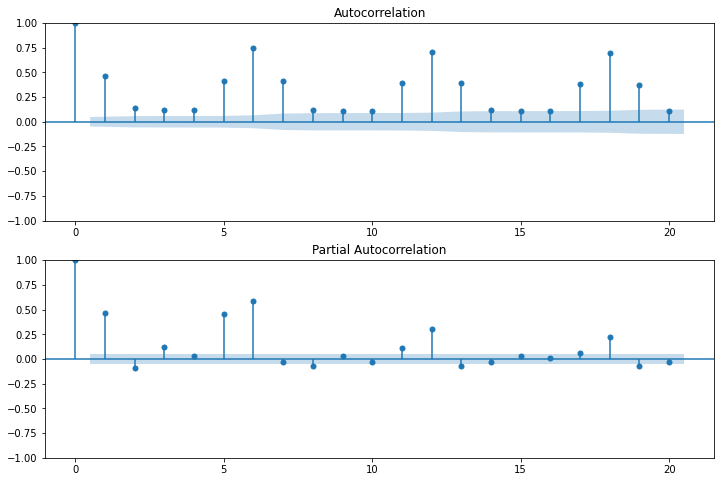

In [25]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df4['total'] , lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df4['total'] , lags=20, ax=ax2)

Há autocorrelação com uma boa margem de confiança os lags 1, 2, 3, 5, 6, 11 e 12 (o 4 não está incluso)

#### 4.2.1.3 Weekly Sales

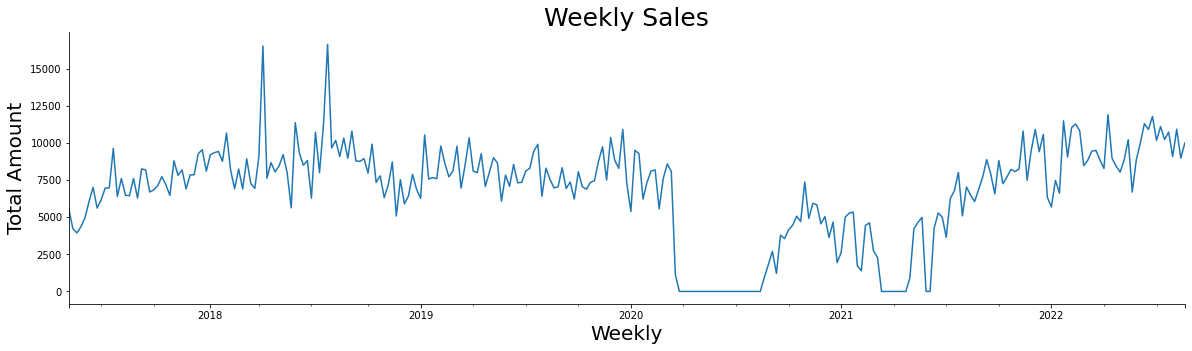

In [26]:
plt.figure(figsize=(20, 5))
df4.resample('w').sum()['total'].plot()
plt.title('Weekly Sales', fontsize=25)
plt.xlabel('Weekly', fontsize=20)
plt.ylabel('Total Amount', fontsize=20)
sns.despine();

#### 4.2.1.4 Monthly Sales

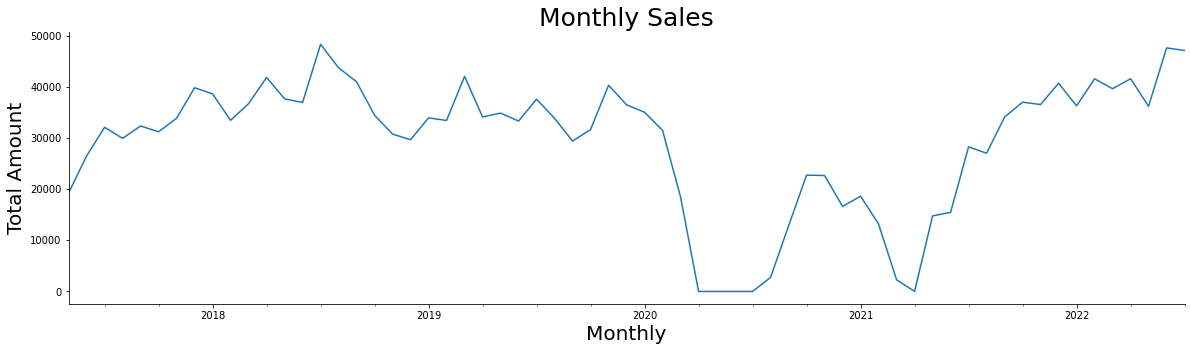

In [27]:
plt.figure(figsize=(20, 5))
df4.resample('m').sum().iloc[:-1]['total'].plot()
plt.title('Monthly Sales', fontsize=25)
plt.xlabel('Monthly', fontsize=20)
plt.ylabel('Total Amount', fontsize=20)
sns.despine();

### 4.2.2 Amount by the Class

In [28]:
temp = df4['2022-07-01':'2022-07-31']

temp = np.sum(temp[['Bar', 'Bilhar', 'Bomboniere', 'Cozinha', 'Gorjeta', 'Tabacaria']], axis=0)
temp = pd.DataFrame(temp, columns=['amount']).reset_index().sort_values('amount', ascending=False)

In [29]:
temp

,class1,amount
0,Bar,29451.93
3,Cozinha,13302.00
4,Gorjeta,3658.20
5,Tabacaria,514.08
2,Bomboniere,101.50
1,Bilhar,77.00


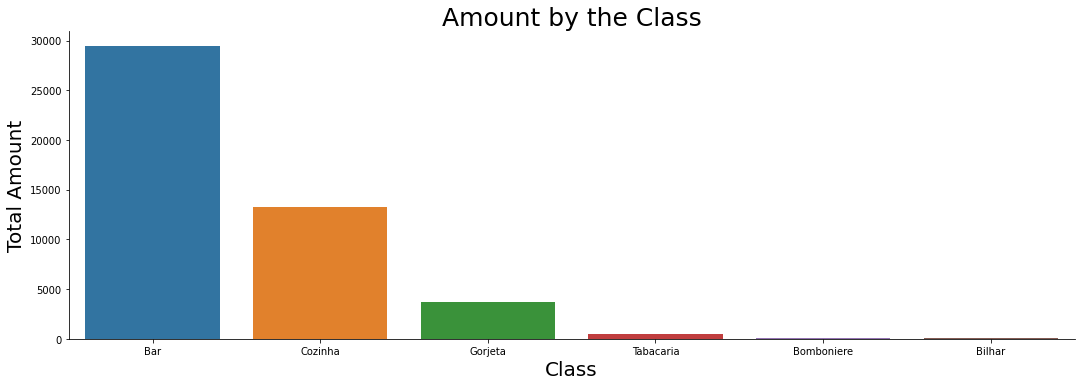

In [30]:
sns.catplot(data=temp, x='class1', y='amount', kind='bar', aspect=3)
plt.title('Amount by the Class', fontsize=25)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Total Amount', fontsize=20)
sns.despine();

## 4.3 Multivariate Analysis

### 4.3.1 Amount by the Class and Time

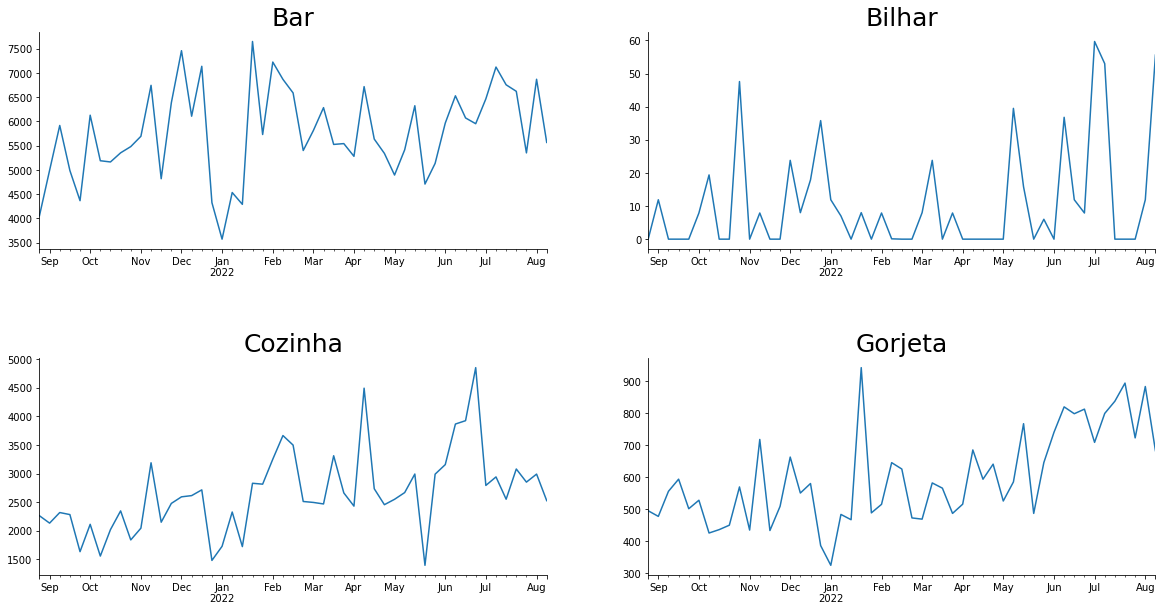

In [31]:
class_1 = ['Bar', 'Bilhar', 'Cozinha', 'Gorjeta']

temp = df4.resample('w')[class_1].sum().iloc[-52:-1]

for i, j in enumerate(class_1):
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(2, 2, i+1)
    temp[j].plot(figsize=(20, 10))
    plt.xlabel('')
    plt.title(j, fontsize=25)
    sns.despine();

## 4.4 Validating Business Hyphothesis

### 4.4.1 Hyphothesy 01:
#### O faturamento total  médio é igual entre os dias semanais: terça-feira e quinta-feira.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

### 4.4.2 Hyphothesy 02:
#### O faturamento total  médio é igual entre os dias semanais: sexta-feira e sábado.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

### 4.4.3 Hyphothesy 03:
#### O faturamento total  médio é igual entre os dias semanais: terça-feira, quarta-feira, quinta-feira e domingo e os dias: sexta-feira e sábado.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

### 4.4.4 Hyphothesy 04:
#### Nos ultimos dois anos, o faturamento total  médio é às quartas-feiras, é igual aos dias: terça-feira, quinta-feira e domingo.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

### 4.4.5 Hyphothesy 05:
#### Nos ultimos três meses, o faturamento total  médio é aos domingos, é igual aos dias: terça-feira e quinta-feira.
* Hipótese Nula (H0): O faturamento médio é igual
* Hipótese Alternativa (H1): O faturamento médio é diferente

# 5.0 Data Filtering

In [32]:
df5 = df4.copy()

In [33]:
# rows
df5.dropna(inplace=True)

# columns
cols_filtering = ['Bar', 'Bilhar', 'Bomboniere', 'Cozinha', 'Gorjeta', 'Tabacaria']
df5.drop(cols_filtering, axis=1, inplace=True)

# 6.0 Data Preparation

In [34]:
df6 = df5.copy()

## 6.1 Normalization

## 6.2 Rescaling

In [35]:
# shifts all
shift_list = [1, 2, 3, 5, 6, 11, 12]

for i in shift_list:
    df6[f'shift_{i}'] = np.log1p(df6[f'shift_{i}'])

## 6.3 Response Variable

In [36]:
# total
df6['total'] = np.log1p(df6['total'])

## 6.4 Transformations

### 6.4.1 Encodings

In [37]:
# day_of_week
map_day_of_week = df6.groupby('day_of_week').agg({'total':'mean'})['total']
df6['day_of_week'] = df6['day_of_week'].map(map_day_of_week)

### 6.4.2 Nature Transformations

In [38]:
# day_of_month
cicle_day_of_month = df6['day_of_month'].max() - df6['day_of_month'].min()
df6['day_of_month_sin'] = df6['day_of_month'].apply(lambda x: np.sin(x*(2*np.pi/cicle_day_of_month)))
df6['day_of_month_cos'] = df6['day_of_month'].apply(lambda x: np.cos(x*(2*np.pi/cicle_day_of_month)))
df6.drop('day_of_month', inplace=True, axis=1)

# month
cicle_month = df6['month'].max() - df6['month'].min()
df6['month'] = df6['month'].apply(lambda x: np.sin(x*(2*np.pi/cicle_day_of_month)))
df6['month'] = df6['month'].apply(lambda x: np.cos(x*(2*np.pi/cicle_day_of_month)))
df6.drop('month', inplace=True, axis=1)

## 6.5 Splits

In [39]:
# train and validation
X_train = df6.loc[df6.index < df6.index.max() - pd.Timedelta(15, 'd')].drop('total', axis=1).values
y_train = df6.loc[df6.index < df6.index.max() - pd.Timedelta(15, 'd'), 'total'].values.ravel()

X_test = df6.loc[df6.index >= df6.index.max() - pd.Timedelta(15, 'd')].drop('total', axis=1).values
y_test = df6.loc[df6.index >= df6.index.max() - pd.Timedelta(15, 'd'), 'total'].values.ravel()

# 7.0 Feature Selection

In [40]:
df7 = df6.copy()

# 8.0 Machine Learning Modeling

In [41]:
df8 = df7.copy()

## 8.1 Linear Regression

In [42]:
# model definition
lr_model = LinearRegression()

# fiting model
lr_fit = lr_model.fit(X_train, y_train)

# predicting
y_hat = lr_fit.predict(X_test)

# metrics
metrics(y_test, y_hat)

MAE: 472.8820438896542
MAPE: 0.37054265172317347
RMSE: 600.5643176928256


### 8.1.1 Cross Validation

In [43]:
error = pd.DataFrame()
error, lr_cross_validation_metrics = cross_validation(df7, error, 5, 'Linear Regression', lr_model)

lr_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,578.557858,0.39646,666.719999
Fold: 4,525.257012,0.475966,661.049998
Fold: 3,487.930085,0.462938,623.976203
Fold: 2,549.075673,0.323488,719.03087
Fold: 1,443.915643,0.272035,586.72469
mean_and_std,516.95 +/- 47.06,0.39 +/- 0.08,651.5 +/- 44.35


## 8.2 Lasso

In [44]:
# model definition
lasso_model = Lasso()

# fiting model
lasso_fit = lasso_model.fit(X_train, y_train)

# predicting
y_hat = lasso_fit.predict(X_test)

# metrics
metrics(y_test, y_hat)

MAE: 619.1210528604764
MAPE: 0.48513315239792937
RMSE: 934.06721434326


### 8.2.1 Cross Validation

In [45]:
error, lr_cross_validation_metrics = cross_validation(df7, error, 5, 'Lasso', lasso_model)

lr_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,725.170873,0.45878,895.74199
Fold: 4,690.834292,0.54578,892.11118
Fold: 3,689.802183,0.570412,868.733797
Fold: 2,808.904176,0.409634,1065.402815
Fold: 1,671.914245,0.345847,948.935934
mean_and_std,717.33 +/- 48.93,0.47 +/- 0.08,934.19 +/- 70.66


## 8.3 Random Forest

In [46]:
# model definition
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=3)

# fiting model
rf_fit = rf_model.fit(X_train, y_train)

# predicting
y_hat = rf_fit.predict(X_test)

# metrics
metrics(y_test, y_hat)

MAE: 532.0058254910894
MAPE: 0.4168710820317045
RMSE: 665.6138095430184


### 8.3.1 Cross Validation

In [47]:
error, lr_cross_validation_metrics = cross_validation(df7, error, 5, 'Random Forest', rf_model)

lr_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,538.398302,0.335111,672.02311
Fold: 4,501.351124,0.382789,643.616529
Fold: 3,505.181675,0.444677,623.236682
Fold: 2,700.206519,0.36263,859.063949
Fold: 1,510.987611,0.287246,652.280351
mean_and_std,551.23 +/- 75.61,0.36 +/- 0.05,690.04 +/- 85.95


## 8.4 XGBoost Regressor

In [48]:
# model definition
xgb_model = XGBRegressor()

# fiting model
xgb_fit = xgb_model.fit(X_train, y_train)

# predicting
y_hat = xgb_fit.predict(X_test)

# metrics
metrics(y_test, y_hat)

MAE: 479.30975738525376
MAPE: 0.37557930311214444
RMSE: 648.1850050173473


### 8.4.1 Cross Validation

In [49]:
error, lr_cross_validation_metrics = cross_validation(df7, error, 5, 'XGBoost Regressor', xgb_model)

lr_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,491.546783,0.331727,637.646374
Fold: 4,383.746576,0.313953,497.383686
Fold: 3,584.940196,0.564138,729.039857
Fold: 2,702.13439,0.414882,855.841517
Fold: 1,501.987167,0.342206,650.252501
mean_and_std,532.87 +/- 106.08,0.39 +/- 0.09,674.03 +/- 117.62


# 9.0 Model Performance

In [50]:
df9 = df8.copy()

## 9.1 Machine Learning Performance

In [51]:
error.T

,MAE,MAPE,RMSE
Linear Regression,516.95 +/- 47.06,0.39 +/- 0.08,651.5 +/- 44.35
Lasso,717.33 +/- 48.93,0.47 +/- 0.08,934.19 +/- 70.66
Random Forest,551.23 +/- 75.61,0.36 +/- 0.05,690.04 +/- 85.95
XGBoost Regressor,532.87 +/- 106.08,0.39 +/- 0.09,674.03 +/- 117.62


## 9.2 Business Performance

# 10.0 Exportings

# 11.0 Deploy

## 10.1 Top_bar_class

## 10.2 Handler API

## 10.3 API Tester

# Time

In [52]:
print(f'O projeto está processando em {round((time.time() - tempo_agora) / 60, 2)} minutos')

O projeto está processando em 0.56 minutos
